# Single Day Backtest Investigation

This notebook walks through a single day backtest to investigate model behavior and data quality.

## Methodology

1. Load historical training data up to target date
2. Build features using rolling statistics (shift -1 to prevent lookahead bias)
3. Train XGBoost model on historical data
4. Generate predictions for target slate
5. Compare predictions to actual results
6. Analyze errors and feature importance

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from src.data.storage.sqlite_storage import SQLiteStorage
from src.data.loaders.historical_loader import HistoricalDataLoader
from src.models.xgboost_model import XGBoostModel
from src.features.pipeline import FeaturePipeline
from src.features.transformers.rolling_stats import RollingStatsTransformer
from src.features.transformers.ewma import EWMATransformer
from src.utils.fantasy_points import calculate_dk_fantasy_points
from src.evaluation.metrics.accuracy import MAPEMetric, RMSEMetric, CorrelationMetric

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Configuration

In [ ]:
from src.utils.feature_config import load_feature_config

DB_PATH = repo_root / 'nba_dfs.db'
TARGET_DATE = '20250205'
NUM_SEASONS = 1
FEATURE_CONFIG = 'default_features'

feature_config = load_feature_config(FEATURE_CONFIG)

if NUM_SEASONS == 1:
    TRAIN_START = HistoricalDataLoader.get_season_start_date(TARGET_DATE)
else:
    TRAIN_START = HistoricalDataLoader.get_previous_season_start_date(TARGET_DATE)

target_dt = datetime.strptime(TARGET_DATE, '%Y%m%d')
train_end_dt = target_dt - timedelta(days=1)
TRAIN_END = train_end_dt.strftime('%Y%m%d')

print(f"Database: {DB_PATH}")
print(f"Target slate date: {TARGET_DATE}")
print(f"Num seasons for training: {NUM_SEASONS}")
print(f"Training period: {TRAIN_START} to {TRAIN_END}")
print(f"  (Season start based on NBA season: Oct 1)")
print(f"\nFeature Configuration: {feature_config.name}")
print(f"  Description: {feature_config.description}")
print(f"  Version: {feature_config.version}")
print(f"  Stats: {len(feature_config.stats)} features")
print(f"  Rolling windows: {feature_config.rolling_windows}")
print(f"  EWMA span: {feature_config.ewma_span}")

## Load Data

Load historical training data and target slate data.

In [3]:
storage = SQLiteStorage(str(DB_PATH))
loader = HistoricalDataLoader(storage)

print("Loading training data...")
training_data = loader.load_historical_player_logs(start_date=TRAIN_START, end_date=TRAIN_END)

if 'plusMinus' in training_data.columns:
    training_data['plusMinus'] = training_data['plusMinus'].apply(lambda x: int(x) if pd.notna(x) else 0)

print(f"Loaded {len(training_data)} training samples")
print(f"Date range: {training_data['gameDate'].min()} to {training_data['gameDate'].max()}")
print(f"Unique players: {training_data['playerID'].nunique()}")

print("\nLoading target slate...")
slate_data = loader.load_slate_data(TARGET_DATE)
salaries_df = slate_data.get('dfs_salaries', pd.DataFrame())

if not salaries_df.empty and 'platform' in salaries_df.columns:
    salaries_df = salaries_df[salaries_df['platform'].str.lower() == 'draftkings']
    print(f"Filtered to DraftKings platform")

print(f"Slate has {len(salaries_df)} players")

training_data.head()

Loading training data...
Loaded 31441 training samples
Date range: 2024-01-10 00:00:00 to 2025-02-03 00:00:00
Unique players: 661

Loading target slate...


Filtered to DraftKings platform
Slate has 380 players


,playerID,longName,team,teamAbv,teamID,gameID,gameDate,pos,mins,pts,reb,ast,stl,blk,TOV,PF,fga,fgm,fgp,fta,ftm,ftp,tptfga,tptfgm,tptfgp,OffReb,DefReb,fantasyPoints,fantasyPts,plusMinus,usage,tech,created_at
0,28128078249,Kris Dunn,UTA,UTA,29,20240110_DEN@UTA,2024-01-10,,26,5,4,3,4,1,2,4,2,2,100.0,0,0,0,1,1,100.0,1,3,27.5,,6,6.71,0,2025-10-06 13:32:27
1,94204466227,Luka Samanic,UTA,UTA,29,20240110_DEN@UTA,2024-01-10,,3,1,0,1,0,0,0,0,0,0,0,2,1,50.0,0,0,0,0,0,2.5,,-5,12.79,0,2025-10-06 13:32:27
2,28498807869,Collin Gillespie,DEN,DEN,8,20240110_DEN@UTA,2024-01-10,,6,8,1,1,0,0,0,0,3,2,66.7,4,3,75.0,1,1,100.0,0,1,10.75,,12,34.83,0,2025-10-06 13:32:27
3,94534209027,Christian Braun,DEN,DEN,8,20240110_DEN@UTA,2024-01-10,,17,5,3,1,1,0,1,1,4,2,50.0,0,0,0,2,1,50.0,0,3,12.25,,-5,12.91,0,2025-10-06 13:32:27
4,943749285539,Peyton Watson,DEN,DEN,8,20240110_DEN@UTA,2024-01-10,,17,3,2,0,0,0,0,1,8,1,12.5,0,0,0,5,1,20.0,1,1,5.5,,-12,20.66,0,2025-10-06 13:32:27


## Feature Engineering

Build features using FeaturePipeline:
- Rolling statistics (mean, std) with shift(1) to prevent lookahead bias
- EWMA with shift(1)
- Target shifted forward by 1 game

In [ ]:
df = training_data.copy()
df['gameDate'] = pd.to_datetime(df['gameDate'], format='%Y%m%d', errors='coerce')
df = df.sort_values(['playerID', 'gameDate'])

if 'plusMinus' in df.columns:
    df['plusMinus'] = df['plusMinus'].apply(lambda x: int(x) if pd.notna(x) else 0)

if 'fpts' not in df.columns:
    print("Calculating fantasy points...")
    df['fpts'] = df.apply(calculate_dk_fantasy_points, axis=1)

print(f"Fantasy points - min: {df['fpts'].min():.1f}, max: {df['fpts'].max():.1f}, mean: {df['fpts'].mean():.1f}")

print("Shifting target forward by 1 game per player...")
df['target'] = df.groupby('playerID')['fpts'].shift(-1)

print(f"\nBuilding features from config: {feature_config.name}")
print(f"Stats: {feature_config.stats}")
print(f"Rolling windows: {feature_config.rolling_windows}")
print(f"EWMA span: {feature_config.ewma_span}")

print("\nBuilding feature pipeline...")
pipeline = feature_config.build_pipeline(FeaturePipeline)

print("Applying transformations...")
df = pipeline.fit_transform(df)

print("Removing original numeric columns...")
df = df.drop(columns=feature_config.stats, errors='ignore')

print(f"Features created: {df.shape[1]} columns")
df.head()

In [5]:
print("Feature columns created:")
feature_cols_list = [col for col in df.columns if any(x in col for x in ['_ma', '_std', '_ewma'])]
print(f"Total: {len(feature_cols_list)}")
for col in sorted(feature_cols_list)[:20]:
    print(f"  {col}")
print("  ...")

Feature columns created:
Total: 147
  DefReb_ewma5
  DefReb_ma10
  DefReb_ma3
  DefReb_ma5
  DefReb_std10
  DefReb_std3
  DefReb_std5
  OffReb_ewma5
  OffReb_ma10
  OffReb_ma3
  OffReb_ma5
  OffReb_std10
  OffReb_std3
  OffReb_std5
  PF_ewma5
  PF_ma10
  PF_ma3
  PF_ma5
  PF_std10
  PF_std3
  ...


In [6]:
df = df.dropna(subset=['target'])

metadata_cols = ['playerID', 'playerName', 'team', 'pos', 'gameDate', 'fpts', 'target', 'pts', 'reb', 'ast', 'stl', 'blk', 'TOV', 'mins']
feature_cols = [col for col in df.columns if col not in metadata_cols and df[col].dtype in ['int64', 'float64', 'bool']]

X_train = df[feature_cols].fillna(0)
y_train = df['target']

print(f"Training data shape: {X_train.shape}")
print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(X_train)}")
print(f"Target mean: {y_train.mean():.2f}")
print(f"Target std: {y_train.std():.2f}")

Training data shape: (30780, 147)
Features: 147
Samples: 30780
Target mean: 21.35
Target std: 15.14


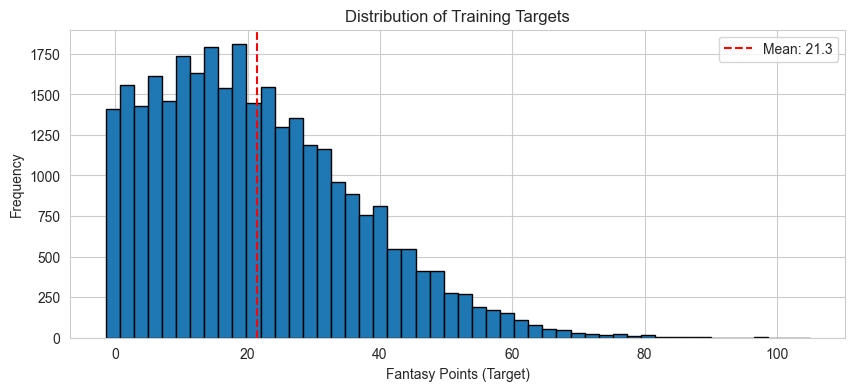

In [7]:
plt.figure(figsize=(10, 4))
plt.hist(y_train, bins=50, edgecolor='black')
plt.xlabel('Fantasy Points (Target)')
plt.ylabel('Frequency')
plt.title('Distribution of Training Targets')
plt.axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: {y_train.mean():.1f}')
plt.legend()
plt.show()

In [8]:
print("Training XGBoost model...")
model = XGBoostModel()
model.train(X_train, y_train)
print("Model trained")

Training XGBoost model...


Model trained


In [ ]:
from src.utils.bayesian_optimizer import optimize_xgboost_cv

RUN_OPTIMIZATION = False
N_OPTIMIZATION_ITERATIONS = 30
CV_FOLDS = 3
SAMPLE_SIZE = 10000

if RUN_OPTIMIZATION:
    print("Running Bayesian optimization...")
    print(f"This may take a while (sample size: {SAMPLE_SIZE}, CV folds: {CV_FOLDS}, iterations: {N_OPTIMIZATION_ITERATIONS})...")
    
    sample_size = min(SAMPLE_SIZE, len(X_train))
    indices = np.random.choice(len(X_train), size=sample_size, replace=False)
    X_sample = X_train.iloc[indices]
    y_sample = y_train.iloc[indices]
    
    print(f"Optimizing on {len(X_sample)} samples")
    
    param_bounds = {
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 500),
        'min_child_weight': (1, 10),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0),
        'gamma': (0.0, 5.0),
        'reg_alpha': (0.0, 1.0),
        'reg_lambda': (0.0, 1.0)
    }
    
    best_params, best_score, history = optimize_xgboost_cv(
        X=X_sample,
        y=y_sample,
        param_bounds=param_bounds,
        cv_folds=CV_FOLDS,
        n_iterations=N_OPTIMIZATION_ITERATIONS,
        scoring='neg_mean_absolute_error',
        random_state=42,
        verbose=True
    )
    
    print("\n" + "=" * 50)
    print("Optimization Complete")
    print("=" * 50)
    print(f"Best CV Score (MAE): {-best_score:.4f}")
    print("\nBest Parameters:")
    for param, value in sorted(best_params.items()):
        print(f"  {param}: {value}")
    
    optimized_config = {
        'max_depth': int(best_params['max_depth']),
        'learning_rate': float(best_params['learning_rate']),
        'n_estimators': int(best_params['n_estimators']),
        'min_child_weight': int(best_params['min_child_weight']),
        'subsample': float(best_params['subsample']),
        'colsample_bytree': float(best_params['colsample_bytree']),
        'gamma': float(best_params['gamma']),
        'reg_alpha': float(best_params['reg_alpha']),
        'reg_lambda': float(best_params['reg_lambda']),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'enable_categorical': True
    }
    
    print("\nTop 10 iterations by score:")
    print(history.nlargest(10, 'score')[['score', 'max_depth', 'learning_rate', 'n_estimators']])
    
else:
    print("Skipping Bayesian optimization (RUN_OPTIMIZATION = False)")
    print("Using default XGBoost hyperparameters")
    optimized_config = None

print("Training XGBoost model...")
if optimized_config:
    print("Using optimized hyperparameters")
    model = XGBoostModel(config=optimized_config)
else:
    print("Using default hyperparameters")
    model = XGBoostModel()

model.train(X_train, y_train)
print("Model trained")

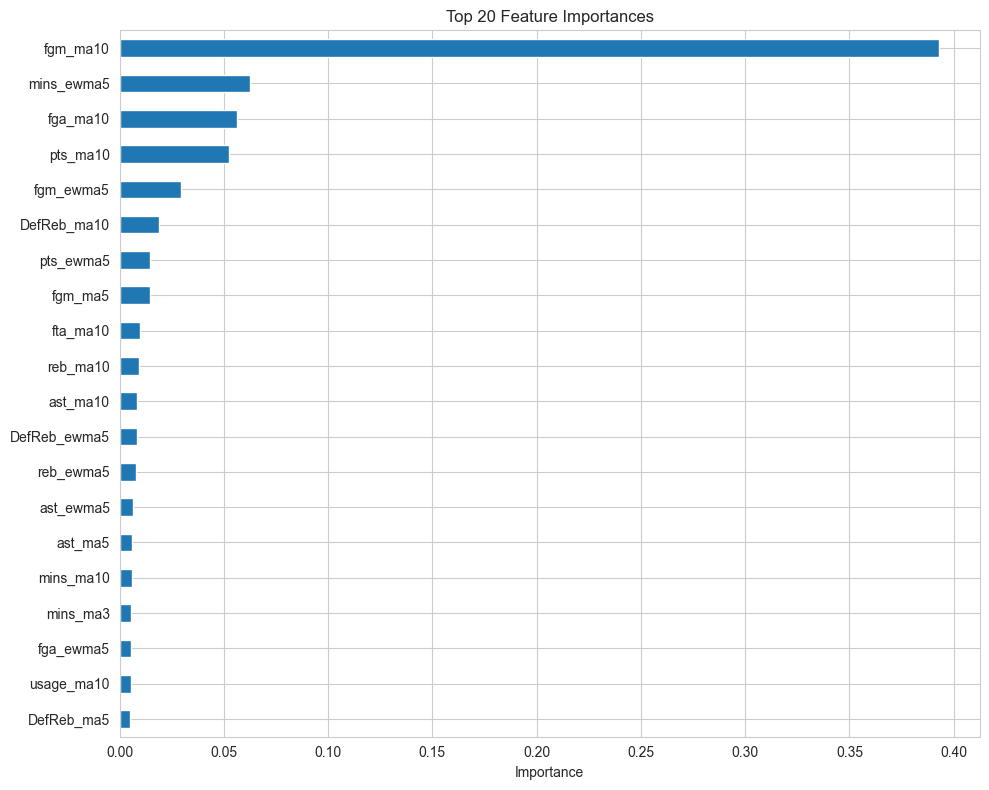

Top 10 features:
 1. fgm_ma10                       0.3930
 2. mins_ewma5                     0.0624
 3. fga_ma10                       0.0565
 4. pts_ma10                       0.0522
 5. fgm_ewma5                      0.0295
 6. DefReb_ma10                    0.0188
 7. pts_ewma5                      0.0145
 8. fgm_ma5                        0.0145
 9. fta_ma10                       0.0098
10. reb_ma10                       0.0094


In [9]:
feature_importance = model.get_feature_importance()

plt.figure(figsize=(10, 8))
feature_importance.head(20).plot(kind='barh')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 features:")
for i, (feat, imp) in enumerate(feature_importance.head(10).items(), 1):
    print(f"{i:2d}. {feat:30s} {imp:.4f}")

## Generate Slate Features

Build features for target slate using last available game for each player.

In [10]:
training_data

,playerID,longName,team,teamAbv,teamID,gameID,gameDate,pos,mins,pts,reb,ast,stl,blk,TOV,PF,fga,fgm,fgp,fta,ftm,ftp,tptfga,tptfgm,tptfgp,OffReb,DefReb,fantasyPoints,fantasyPts,plusMinus,usage,tech,created_at
0,28128078249,Kris Dunn,UTA,UTA,29,20240110_DEN@UTA,2024-01-10,,26,5,4,3,4,1,2,4,2,2,100.0,0,0,0,1,1,100.0,1,3,27.5,,6,6.71,0,2025-10-06 13:32:27
1,94204466227,Luka Samanic,UTA,UTA,29,20240110_DEN@UTA,2024-01-10,,3,1,0,1,0,0,0,0,0,0,0,2,1,50.0,0,0,0,0,0,2.5,,-5,12.79,0,2025-10-06 13:32:27
2,28498807869,Collin Gillespie,DEN,DEN,8,20240110_DEN@UTA,2024-01-10,,6,8,1,1,0,0,0,0,3,2,66.7,4,3,75.0,1,1,100.0,0,1,10.75,,12,34.83,0,2025-10-06 13:32:27
3,94534209027,Christian Braun,DEN,DEN,8,20240110_DEN@UTA,2024-01-10,,17,5,3,1,1,0,1,1,4,2,50.0,0,0,0,2,1,50.0,0,3,12.25,,-5,12.91,0,2025-10-06 13:32:27
4,943749285539,Peyton Watson,DEN,DEN,8,20240110_DEN@UTA,2024-01-10,,17,3,2,0,0,0,0,1,8,1,12.5,0,0,0,5,1,20.0,1,1,5.5,,-12,20.66,0,2025-10-06 13:32:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31436,94154299027,Justin Champagnie,WAS,WAS,30,20250203_WAS@CHA,2025-02-03,,13,5,2,0,1,2,0,0,3,2,66.7,0,0,0,2,1,50.0,0,2,16.5,,26,9.22,0,2025-10-06 12:33:01
31437,28938991482,Malcolm Brogdon,WAS,WAS,30,20250203_WAS@CHA,2025-02-03,,22,16,4,7,0,0,2,1,9,4,44.4,10,8,80.0,2,0,0.0,1,3,29.5,,12,27.97,0,2025-10-06 12:33:01
31438,947740472289,Bilal Coulibaly,WAS,WAS,30,20250203_WAS@CHA,2025-02-03,,37,26,5,3,2,0,0,2,16,9,56.2,5,4,80.0,8,4,50.0,0,5,42.75,,-5,19.66,0,2025-10-06 12:33:01
31439,28158547499,DaQuan Jeffries,CHA,CHA,4,20250203_WAS@CHA,2025-02-03,,12,2,1,1,0,0,0,2,4,1,25.0,0,0,0,3,0,0.0,0,1,4.75,,-25,14.25,0,2025-10-06 12:33:01


In [11]:
if 'longName' in salaries_df.columns and 'playerName' not in salaries_df.columns:
    salaries_df['playerName'] = salaries_df['longName']

training_data_for_slate = training_data.copy()
training_data_for_slate['gameDate'] = pd.to_datetime(training_data_for_slate['gameDate'], format='%Y%m%d', errors='coerce')

if 'fpts' not in training_data_for_slate.columns:
    training_data_for_slate['fpts'] = training_data_for_slate.apply(calculate_dk_fantasy_points, axis=1)

training_features = pipeline.transform(training_data_for_slate)

slate_features = []

for _, player_row in salaries_df.iterrows():
    player_id = player_row['playerID']
    
    player_features = training_features[training_features['playerID'] == player_id]
    
    if len(player_features) < min(ROLLING_WINDOWS):
        continue
    
    last_row = player_features.iloc[-1]
    
    features = {
        'playerID': player_id,
        'playerName': player_row.get('playerName', ''),
        'team': player_row.get('team', ''),
        'pos': player_row.get('pos', ''),
        'salary': player_row.get('salary', 0)
    }
    
    metadata_cols = ['playerID', 'playerName', 'team', 'pos', 'gameDate', 'fpts', 'pts', 'reb', 'ast', 'stl', 'blk', 'TOV', 'mins']
    for col in last_row.index:
        if col not in metadata_cols and training_features[col].dtype in ['int64', 'float64', 'bool']:
            features[col] = last_row[col]
    
    slate_features.append(features)

slate_features_df = pd.DataFrame(slate_features)
print(f"Generated features for {len(slate_features_df)} players")
slate_features_df.head()

C:\Users\antho\AppData\Local\Temp\ipykernel_20688\264213778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salaries_df['playerName'] = salaries_df['longName']


Generated features for 366 players


,playerID,playerName,team,pos,salary,PF,fga,fgm,fgp,fta,ftm,ftp,tptfga,tptfgm,tptfgp,OffReb,DefReb,plusMinus,usage,pts_ma3,pts_std3,pts_ma5,pts_std5,pts_ma10,pts_std10,reb_ma3,reb_std3,reb_ma5,reb_std5,reb_ma10,reb_std10,ast_ma3,ast_std3,ast_ma5,ast_std5,ast_ma10,ast_std10,stl_ma3,stl_std3,stl_ma5,stl_std5,stl_ma10,stl_std10,blk_ma3,blk_std3,blk_ma5,blk_std5,blk_ma10,blk_std10,TOV_ma3,...,tptfgp_std3,tptfgp_ma5,tptfgp_std5,tptfgp_ma10,tptfgp_std10,OffReb_ma3,OffReb_std3,OffReb_ma5,OffReb_std5,OffReb_ma10,OffReb_std10,DefReb_ma3,DefReb_std3,DefReb_ma5,DefReb_std5,DefReb_ma10,DefReb_std10,usage_ma3,usage_std3,usage_ma5,usage_std5,usage_ma10,usage_std10,plusMinus_ma3,plusMinus_std3,plusMinus_ma5,plusMinus_std5,plusMinus_ma10,plusMinus_std10,pts_ewma5,reb_ewma5,ast_ewma5,stl_ewma5,blk_ewma5,TOV_ewma5,mins_ewma5,PF_ewma5,fga_ewma5,fgm_ewma5,fgp_ewma5,fta_ewma5,ftm_ewma5,ftp_ewma5,tptfga_ewma5,tptfgm_ewma5,tptfgp_ewma5,OffReb_ewma5,DefReb_ewma5,usage_ewma5,plusMinus_ewma5
0,28908111729,Nikola Jokic,DEN,C,12800,2,13,9,69.2,10,8,80.0,3,1,33.3,1,13,11,22.42,24.333333,6.350853,25.2,6.534524,24.2,7.598245,9.333333,3.511885,8.6,4.159327,11.8,5.116422,12.000000,5.567764,12.2,4.086563,11.8,3.457681,2.666667,1.154701,1.8,1.483240,2.0,1.333333,0.666667,0.577350,0.6,0.547723,0.9,0.994429,4.000000,...,19.246385,42.64,16.892395,44.66,21.563560,1.000000,1.000000,1.2,0.836660,1.9,1.370320,8.333333,3.214550,7.4,3.847077,9.9,4.605552,27.636667,3.165475,27.156,2.362442,24.570,4.951191,-1.666667,1.527525,-5.6,10.406729,5.3,14.283246,26.299692,10.758462,13.191249,2.468955,0.762269,4.037442,35.908559,2.210142,16.418780,9.715197,59.089497,5.611818,4.891372,83.784670,5.026765,1.977924,43.183242,1.453463,9.304999,27.574316,-0.620086
1,28118035349,Giannis Antetokounmpo,MIL,PF,11800,3,21,14,66.7,6,0,0.0,3,2,66.7,4,7,-3,31.91,36.333333,2.309401,34.0,5.291503,32.2,5.223877,14.666667,3.055050,13.8,2.489980,13.2,2.097618,6.000000,1.000000,4.6,2.302173,5.1,3.348300,0.666667,1.154701,0.4,0.894427,0.4,0.699206,0.333333,0.577350,1.0,1.224745,0.9,0.994429,2.666667,...,0.000000,0.00,0.000000,0.00,0.000000,3.000000,1.732051,2.6,1.341641,2.8,2.043961,11.666667,4.725816,11.2,3.420526,10.4,2.875181,37.723333,2.655981,37.162,4.374142,36.392,4.517494,-1.666667,17.925773,0.8,16.649324,7.8,19.001754,34.897872,13.820515,5.237019,0.371399,0.718776,2.747620,34.931945,2.897204,22.259558,13.959667,62.689978,12.121803,6.978015,55.495942,0.659040,0.000523,0.051313,3.065212,10.755303,37.228451,-1.370550
2,28778646789,Shai Gilgeous-Alexander,OKC,SG,10800,1,19,15,78.9,3,2,66.7,3,2,66.7,0,3,34,42.57,38.666667,11.930353,40.2,11.903781,36.6,9.743374,4.666667,1.527525,4.6,2.701851,4.2,2.201010,4.666667,4.041452,5.2,3.033150,5.9,3.142893,1.333333,1.527525,1.4,1.516575,1.9,1.286684,0.666667,1.154701,0.8,1.095445,0.7,0.823273,3.000000,...,16.650025,32.66,11.866887,36.66,24.073969,1.333333,1.527525,1.6,1.341641,1.1,1.100505,3.333333,0.577350,3.0,1.870829,3.1,1.663330,37.746667,2.758846,39.476,6.969522,37.789,5.981875,4.666667,10.969655,3.2,9.808160,13.8,13.878841,37.255905,4.531687,6.069677,1.224167,0.897487,3.127713,34.572604,2.550907,24.072548,12.457890,51.853369,12.256440,10.821756,89.429583,5.414838,1.518369,29.835851,1.539575,2.992112,37.812042,8.307369
3,943740414489,Victor Wembanyama,SA,C,10800,3,20,10,50.0,7,5,71.4,6,2,33.3,2,8,8,34.15,24.333333,5.131601,24.8,4.868265,21.2,6.356099,12.666667,1.154701,11.8,1.483240,11.5,1.840894,2.333333,1.527525,3.2,1.923538,3.1,1.663330,1.333333,1.154701,1.0,1.000000,1.3,1.059350,3.333333,2.516611,3.2,2.280351,4.3,2.668749,2.666667,...,11.282878,39.60,8.345957,37.39,6.851188,1.333333,0.577350,1.2,0.447214,1.5,1.080123,11.333333,0.577350,10.6,1.140175,10.0,2.108185,27.640000,3.387875,29.598,3.654445,27.687,5.437348,-3.666667,11.372481,-0.6,13.427584,-1.1,14.051097,24.887749,12.415255,2.707269,1.041855,4.081347,2.560970,33.024974,2.634072,18.255217,8.624742,47.121410,4.716656,4.045499,68.119031,8.704236,3.592766,41.340961,1.399605,11.015650,29.036094,0.

## Generate Predictions

In [12]:
## Generate Predictions

# Use the same feature columns from training
print(f"Feature columns expected: {len(feature_cols)}")
print(f"Slate DataFrame columns: {len(slate_features_df.columns)}")

# Check which features are missing
slate_cols = set(slate_features_df.columns)
expected_cols = set(feature_cols)
missing_features = expected_cols - slate_cols
extra_features = slate_cols - expected_cols

if missing_features:
    print(f"\n⚠️  WARNING: {len(missing_features)} features missing from slate data:")
    for feat in sorted(list(missing_features))[:10]:
        print(f"  - {feat}")
    if len(missing_features) > 10:
        print(f"  ... and {len(missing_features) - 10} more")

if extra_features:
    print(f"\nℹ️  {len(extra_features)} extra columns in slate data (will be ignored)")

# Select features, filling missing ones with 0
X_slate = slate_features_df.reindex(columns=feature_cols, fill_value=0).fillna(0)

# Verify we have the right features
print(f"\nSlate features shape: {X_slate.shape}")
print(f"Expected features: {len(feature_cols)}")
print(f"Feature match: {set(X_slate.columns) == set(feature_cols)}")

predictions = model.predict(X_slate)

projections_df = slate_features_df[['playerID', 'playerName', 'team', 'pos', 'salary']].copy()
projections_df['projected_fpts'] = predictions
projections_df['salary'] = pd.to_numeric(projections_df['salary'], errors='coerce')
projections_df['value'] = projections_df['projected_fpts'] / (projections_df['salary'] / 1000)

print(f"\n✓ Projections generated for {len(projections_df)} players")
print(f"Projected points - min: {predictions.min():.1f}, max: {predictions.max():.1f}, mean: {predictions.mean():.1f}")

projections_df.sort_values('projected_fpts', ascending=False).head(10)

Feature columns expected: 147
Slate DataFrame columns: 166

ℹ️  19 extra columns in slate data (will be ignored)

Slate features shape: (366, 147)
Expected features: 147
Feature match: True

✓ Projections generated for 366 players
Projected points - min: 4.1, max: 60.2, mean: 19.4


,playerID,playerName,team,pos,salary,projected_fpts,value
0,28908111729,Nikola Jokic,DEN,C,12800,60.157845,4.699832
1,28118035349,Giannis Antetokounmpo,MIL,PF,11800,57.116291,4.840364
8,28118309129,Domantas Sabonis,SAC,C,9800,53.382175,5.447161
4,94804285527,Cade Cunningham,DET,SG,10500,49.213215,4.686973
2,28778646789,Shai Gilgeous-Alexander,OKC,SG,10800,49.066540,4.543198
7,94344202027,Anthony Edwards,MIN,SG,9800,46.455906,4.740399
20,94614279027,Franz Wagner,ORL,PF,8500,46.188175,5.433903
38,28998641179,Malik Monk,SAC,SG,7700,45.971188,5.970284
9,28698011729,Joel Embiid,PHI,C,9700,45.964207,4.738578
12,28898319129,Devin Booker,PHO,SG,9300,44.539116,4.789152


In [13]:
print("Top 10 by value (fpts per $1000):")
projections_df.sort_values('value', ascending=False)[['playerName', 'team', 'pos', 'salary', 'projected_fpts', 'value']].head(10)

Top 10 by value (fpts per $1000):


,playerName,team,pos,salary,projected_fpts,value
299,Jalen Johnson,ATL,SF,3000,39.574017,13.191339
359,Dejounte Murray,NO,PG,3000,39.509689,13.169896
327,Brandon Miller,CHA,SG,3000,29.919851,9.973284
302,Jaden Ivey,DET,SG,3000,26.175346,8.725115
274,Vince Williams Jr.,MEM,SF,3000,24.968163,8.322721
335,Jared McCain,PHI,SG,3000,24.179142,8.059714
265,Herbert Jones,NO,SG,3000,23.918320,7.972773
363,Grant Williams,CHA,PF,3000,23.650581,7.883527
358,Moe Wagner,ORL,C,3000,22.746220,7.582073
98,Isaiah Collier,UTA,PG,5200,32.951866,6.336897


## Load Actuals and Evaluate

In [14]:
filters = {'start_date': TARGET_DATE, 'end_date': TARGET_DATE}
actuals_df = storage.load('box_scores', filters)

if not actuals_df.empty:
    actuals_df['actual_fpts'] = actuals_df.apply(calculate_dk_fantasy_points, axis=1)
    
    if 'longName' in actuals_df.columns and 'playerName' not in actuals_df.columns:
        actuals_df['playerName'] = actuals_df['longName']
    
    if 'plusMinus' in actuals_df.columns:
        actuals_df['plusMinus'] = actuals_df['plusMinus'].apply(lambda x: int(x) if pd.notna(x) else 0)
    
    print(f"Loaded actuals for {len(actuals_df)} players")
    print(f"Actual points - min: {actuals_df['actual_fpts'].min():.1f}, max: {actuals_df['actual_fpts'].max():.1f}, mean: {actuals_df['actual_fpts'].mean():.1f}")
else:
    print("No actual data found for target date")

actuals_df.head()

Loaded actuals for 248 players
Actual points - min: 0.0, max: 73.0, mean: 20.7


,playerID,longName,team,teamAbv,teamID,gameID,gameDate,pos,mins,pts,reb,ast,stl,blk,TOV,PF,fga,fgm,fgp,fta,ftm,ftp,tptfga,tptfgm,tptfgp,OffReb,DefReb,fantasyPoints,fantasyPts,plusMinus,usage,tech,created_at,actual_fpts,playerName
0,94814419047,Ayo Dosunmu,CHI,CHI,5,20250205_CHI@MIN,20250205,,36,11,0,4,2,0,2,3,10,5,50.0,0,0,0,5,1,20.0,0,0,21.0,,-8,15.43,0,2025-10-06 12:33:01,20.00,Ayo Dosunmu
1,28858866027,Naz Reid,MIN,MIN,18,20250205_CHI@MIN,20250205,,36,22,10,6,1,2,1,3,19,8,42.1,2,2,100.0,10,4,40.0,2,8,51.5,,16,22.95,0,2025-10-06 12:33:01,50.50,Naz Reid
2,94704402047,Coby White,CHI,CHI,5,20250205_CHI@MIN,20250205,,32,20,0,4,0,0,1,4,11,5,45.5,6,6,100.0,6,4,66.7,0,0,25.0,,-15,21.18,0,2025-10-06 12:33:01,25.50,Coby White
3,941447431869,Julian Phillips,CHI,CHI,5,20250205_CHI@MIN,20250205,,17,2,4,0,0,1,0,1,2,1,50.0,0,0,0,0,0,0,2,2,10.0,,-4,5.45,0,2025-10-06 12:33:01,9.00,Julian Phillips
4,94244296527,Jaylen Clark,MIN,MIN,18,20250205_CHI@MIN,20250205,,22,5,1,0,0,1,1,3,2,2,100.0,0,0,0,1,1,100.0,1,0,8.25,,7,5.4,0,2025-10-06 12:33:01,7.75,Jaylen Clark


In [15]:
merged = projections_df.merge(
    actuals_df[['playerID', 'actual_fpts']],
    on='playerID',
    how='inner'
)

merged['error'] = merged['actual_fpts'] - merged['projected_fpts']
merged['abs_error'] = merged['error'].abs()
merged['pct_error'] = (merged['abs_error'] / merged['actual_fpts'] * 100).replace([np.inf, -np.inf], np.nan)

print(f"Matched {len(merged)} players")
merged.head(10)

Matched 246 players


,playerID,playerName,team,pos,salary,projected_fpts,value,actual_fpts,error,abs_error,pct_error
0,28908111729,Nikola Jokic,DEN,C,12800,60.157845,4.699832,68.00,7.842155,7.842155,11.532582
1,28778646789,Shai Gilgeous-Alexander,OKC,SG,10800,49.066540,4.543198,73.00,23.933460,23.933460,32.785562
2,943740414489,Victor Wembanyama,SA,C,10800,41.093208,3.804927,45.00,3.906792,3.906792,8.681759
3,94804285527,Cade Cunningham,DET,SG,10500,49.213215,4.686973,67.75,18.536785,18.536785,27.360568
4,94854409027,Tyrese Maxey,PHI,PG,10000,42.662712,4.266271,49.75,7.087288,7.087288,14.245805
5,94344202027,Anthony Edwards,MIN,SG,9800,46.455906,4.740399,66.25,19.794094,19.794094,29.877878
6,28118309129,Domantas Sabonis,SAC,C,9800,53.382175,5.447161,41.25,-12.132175,12.132175,29.411334
7,28978646789,Trae Young,ATL,PG,9600,44.428776,4.627997,51.50,7.071224,7.071224,13.730532
8,94084226527,Scottie Barnes,TOR,SG,9300,41.210365,4.431222,36.50,-4.710365,4.710365,12.905110
9,28898319129,Devin Booker,PHO,SG,9300,44.539116,4.789152,23.00,-21.539116,21.539116,93.648330


## Evaluation Metrics

In [16]:
mape_metric = MAPEMetric()
rmse_metric = RMSEMetric()
corr_metric = CorrelationMetric()

y_true = merged['actual_fpts'].values
y_pred = merged['projected_fpts'].values

mape = mape_metric.calculate(y_true, y_pred)
rmse = rmse_metric.calculate(y_true, y_pred)
corr = corr_metric.calculate(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"Correlation: {corr:.3f}")
print(f"Mean Error: {merged['error'].mean():.2f}")
print(f"Mean Absolute Error: {merged['abs_error'].mean():.2f}")

MAPE: 94.42%
RMSE: 10.52
Correlation: 0.734
Mean Error: 0.45
Mean Absolute Error: 8.21


## Error Analysis

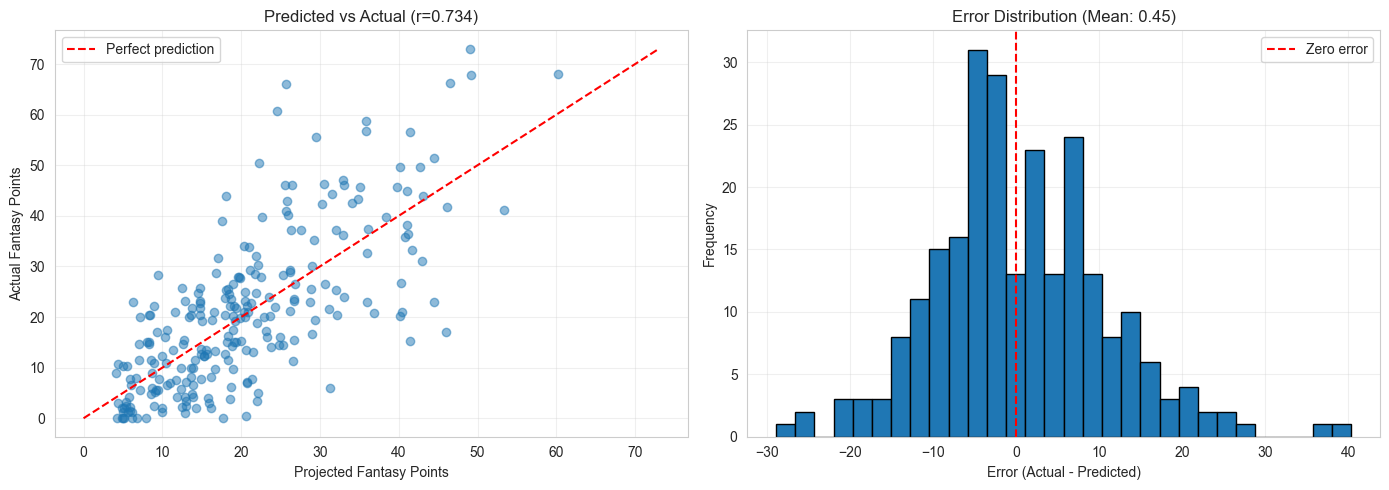

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(merged['projected_fpts'], merged['actual_fpts'], alpha=0.5)
axes[0].plot([0, merged['actual_fpts'].max()], [0, merged['actual_fpts'].max()], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Projected Fantasy Points')
axes[0].set_ylabel('Actual Fantasy Points')
axes[0].set_title(f'Predicted vs Actual (r={corr:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(merged['error'], bins=30, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', label='Zero error')
axes[1].set_xlabel('Error (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Error Distribution (Mean: {merged["error"].mean():.2f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
print("Top 10 overestimates (predicted too high):")
print(merged.sort_values('error')[['playerName', 'team', 'pos', 'projected_fpts', 'actual_fpts', 'error']].head(10))

print("\nTop 10 underestimates (predicted too low):")
print(merged.sort_values('error', ascending=False)[['playerName', 'team', 'pos', 'projected_fpts', 'actual_fpts', 'error']].head(10))

Top 10 overestimates (predicted too high):
           playerName team pos  projected_fpts  actual_fpts      error
30         Malik Monk  SAC  SG       45.971188        17.00 -28.971188
13      Mark Williams  CHA   C       41.390102        15.25 -26.140102
40   D'Angelo Russell  BKN  PG       31.277632         6.00 -25.277632
9        Devin Booker  PHO  SG       44.539116        23.00 -21.539116
97    Duncan Robinson  MIA  SG       20.607861         0.50 -20.107861
25        Zach LaVine  SAC  SG       40.140690        20.25 -19.890690
29       Jamal Murray  DEN  PG       40.452240        21.00 -19.452240
134      Caris LeVert  CLE  SG       21.960590         3.50 -18.460590
110  Ricky Council IV  PHI  SG       17.720125         0.00 -17.720125
70      Malik Beasley  DET  SG       22.101400         5.00 -17.101400

Top 10 underestimates (predicted too low):
                  playerName team pos  projected_fpts  actual_fpts      error
47        Michael Porter Jr.  DEN  SF       25.661137 

In [19]:
print("Highest absolute errors:")
print(merged.sort_values('abs_error', ascending=False)[['playerName', 'team', 'pos', 'projected_fpts', 'actual_fpts', 'error', 'abs_error']].head(10))

Highest absolute errors:
                  playerName team pos  projected_fpts  actual_fpts      error  \
47        Michael Porter Jr.  DEN  SF       25.661137        66.00  40.338863   
64              Bobby Portis  MIL  PF       24.591352        60.75  36.158648   
30                Malik Monk  SAC  SG       45.971188        17.00 -28.971188   
49                  Naz Reid  MIN   C       22.227419        50.50  28.272581   
13             Mark Williams  CHA   C       41.390102        15.25 -26.140102   
45            Onyeka Okongwu  ATL   C       29.550377        55.50  25.949623   
118       Brandin Podziemski   GS  SG       18.118603        44.00  25.881397   
40          D'Angelo Russell  BKN  PG       31.277632         6.00 -25.277632   
1    Shai Gilgeous-Alexander  OKC  SG       49.066540        73.00  23.933460   
24               Evan Mobley  CLE  PF       35.842949        58.75  22.907051   

     abs_error  
47   40.338863  
64   36.158648  
30   28.971188  
49   28.272581 

## Performance by Salary Tier

In [20]:
merged['salary_tier'] = pd.cut(merged['salary'], bins=[0, 4000, 6000, 8000, 15000], labels=['Low', 'Mid', 'High', 'Elite'])

tier_stats = merged.groupby('salary_tier').agg({
    'playerID': 'count',
    'projected_fpts': 'mean',
    'actual_fpts': 'mean',
    'abs_error': 'mean',
    'pct_error': 'mean'
}).rename(columns={'playerID': 'count'})

print("Performance by salary tier:")
print(tier_stats)

Performance by salary tier:
             count  projected_fpts  actual_fpts  abs_error   pct_error
salary_tier                                                           
Low            118       11.798960    11.470339   6.290321  115.774187
Mid             75       21.953215    23.050000   8.520986   99.292299
High            28       32.789291    33.410714  12.491594   52.321764
Elite           25       42.511265    44.510000  11.519162   32.325445


C:\Users\antho\AppData\Local\Temp\ipykernel_20688\14600087.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_stats = merged.groupby('salary_tier').agg({


<Figure size 1000x500 with 0 Axes>

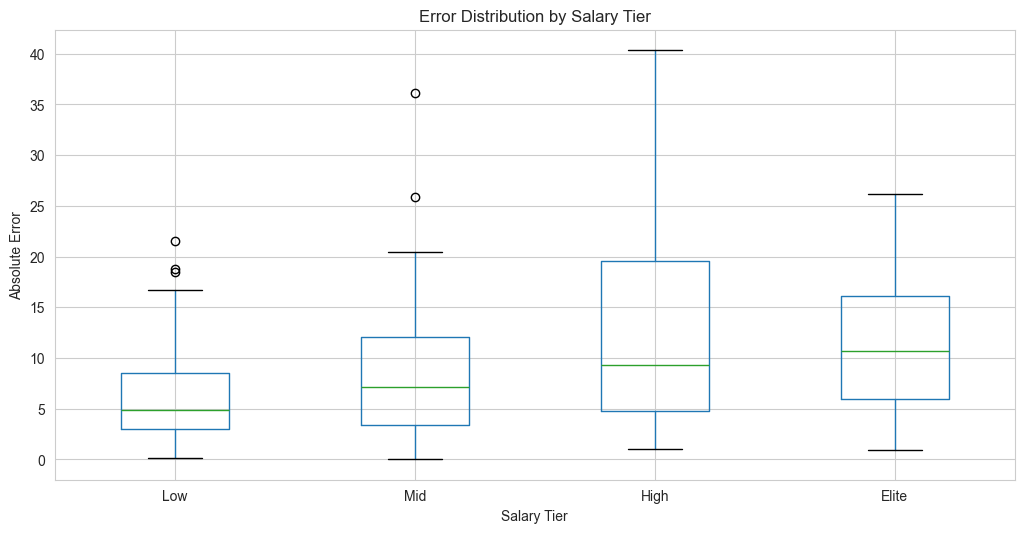

In [21]:
plt.figure(figsize=(10, 5))
merged.boxplot(column='abs_error', by='salary_tier')
plt.xlabel('Salary Tier')
plt.ylabel('Absolute Error')
plt.title('Error Distribution by Salary Tier')
plt.suptitle('')
plt.show()

## Summary Statistics

In [22]:
print(f"Date: {TARGET_DATE}")
print(f"Players evaluated: {len(merged)}")
print(f"\nPerformance Metrics:")
print(f"  MAPE: {mape:.2f}%")
print(f"  RMSE: {rmse:.2f}")
print(f"  Correlation: {corr:.3f}")
print(f"\nError Statistics:")
print(f"  Mean error: {merged['error'].mean():.2f}")
print(f"  Mean absolute error: {merged['abs_error'].mean():.2f}")
print(f"  Median absolute error: {merged['abs_error'].median():.2f}")
print(f"  Std dev of error: {merged['error'].std():.2f}")
print(f"\nProjection Range:")
print(f"  Min projected: {merged['projected_fpts'].min():.1f}")
print(f"  Max projected: {merged['projected_fpts'].max():.1f}")
print(f"  Mean projected: {merged['projected_fpts'].mean():.1f}")
print(f"\nActual Range:")
print(f"  Min actual: {merged['actual_fpts'].min():.1f}")
print(f"  Max actual: {merged['actual_fpts'].max():.1f}")
print(f"  Mean actual: {merged['actual_fpts'].mean():.1f}")

Date: 20250205
Players evaluated: 246

Performance Metrics:
  MAPE: 94.42%
  RMSE: 10.52
  Correlation: 0.734

Error Statistics:
  Mean error: 0.45
  Mean absolute error: 8.21
  Median absolute error: 6.76
  Std dev of error: 10.53

Projection Range:
  Min projected: 4.1
  Max projected: 60.2
  Mean projected: 20.4

Actual Range:
  Min actual: 0.0
  Max actual: 73.0
  Mean actual: 20.9
